## Experiment 1 - Bucket

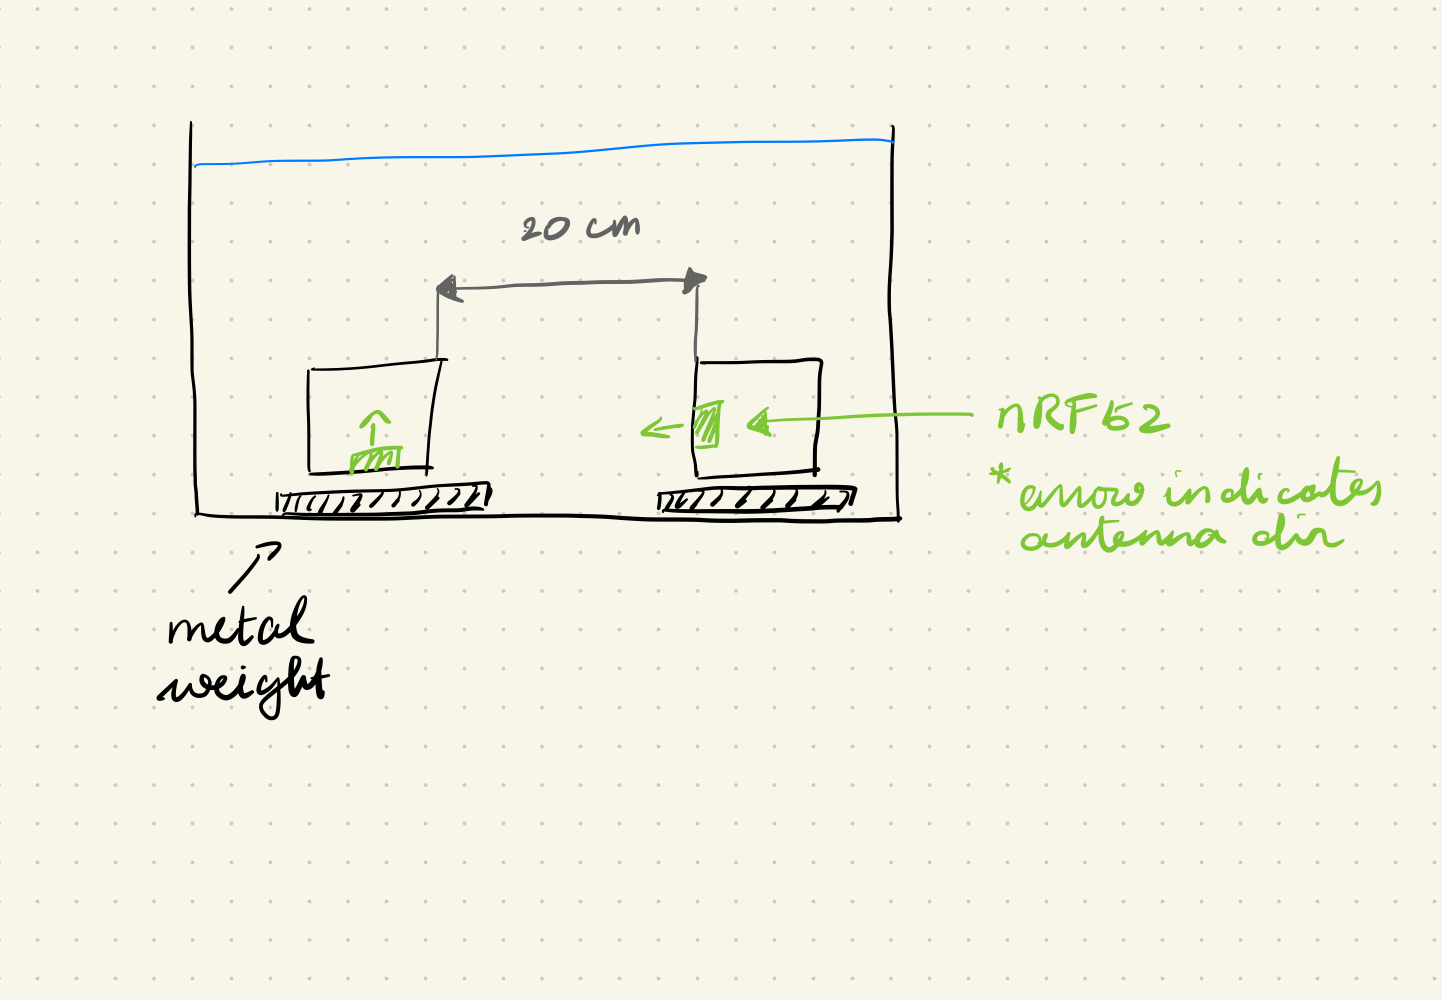

In [1]:
import pandas as pd
import duckdb

headers = (
    'tx_mode', 'tx_channel', 'tx_power', 
    'sent', 'received', 'crcok', 'total_rssi',
    'ticks', 'time_s',
)

df = pd.read_csv('results_20cm.csv', names=headers)
df.head()

,tx_mode,tx_channel,tx_power,sent,received,crcok,total_rssi,ticks,time_s
0,0,0,0,294,173,32,16103,39665202,4.95815
1,0,0,0,294,156,18,14546,39801041,4.97513
2,0,0,0,294,150,11,13993,39936881,4.99211
3,0,0,0,294,130,2,12125,39665202,4.95815
4,0,0,0,294,143,6,13358,39665202,4.95815


In [2]:
df['avg_rssi'] = df['total_rssi'] / df['received']
df['throughput_bps'] = df['crcok'] * 255 * 8 / df['time_s']
df.head()

,tx_mode,tx_channel,tx_power,sent,received,crcok,total_rssi,ticks,time_s,avg_rssi,throughput_bps
0,0,0,0,294,173,32,16103,39665202,4.95815,93.080925,13166.200439
1,0,0,0,294,156,18,14546,39801041,4.97513,93.243590,7380.711474
2,0,0,0,294,150,11,13993,39936881,4.99211,93.286667,4495.093145
3,0,0,0,294,130,2,12125,39665202,4.95815,93.269231,822.887527
4,0,0,0,294,143,6,13358,39665202,4.95815,93.412587,2468.662582


In [3]:
MODE_NAMES = (
    'BLE_LR125KBIT',
    'BLE_LR500KBIT',
    'BLE_1MBIT',
    'BLE_2MBIT',
    'NRF_1MBIT',
    'NRF_2MBIT',
)

In [4]:
table_mode_0 = duckdb.sql("""
    SELECT tx_channel, tx_power, AVG(avg_rssi), AVG(throughput_bps), AVG(sent), AVG(received) - 1, AVG(crcok),
    FROM df WHERE tx_mode = 0 
    GROUP BY tx_channel, tx_power
    ORDER BY tx_channel, tx_power
""")

table_mode_1 = duckdb.sql("""
    SELECT tx_channel, tx_power, AVG(avg_rssi), AVG(throughput_bps), AVG(sent), AVG(received) - 1, AVG(crcok),
    FROM df WHERE tx_mode = 1 
    GROUP BY tx_channel, tx_power
    ORDER BY tx_channel, tx_power
""")

table_mode_0

┌────────────┬──────────┬───────────────────┬─────────────────────┬───────────┬─────────────────────┬────────────┐
│ tx_channel │ tx_power │   avg(avg_rssi)   │ avg(throughput_bps) │ avg(sent) │ (avg(received) - 1) │ avg(crcok) │
│   int64    │  int64   │      double       │       double        │  double   │       double        │   double   │
├────────────┼──────────┼───────────────────┼─────────────────────┼───────────┼─────────────────────┼────────────┤
│          0 │        0 │ 93.25859988951319 │   5666.711033633975 │     294.0 │               149.4 │       13.8 │
│          0 │        2 │ 91.83325159312255 │   93971.30358479913 │     294.0 │               236.2 │      229.8 │
│          0 │        4 │ 89.91135472378087 │  115646.49136888245 │     294.0 │               283.0 │      283.0 │
│          0 │        6 │ 88.36358960009524 │  118752.18680712317 │     294.0 │               290.6 │      290.6 │
│          0 │        8 │ 86.81164706560591 │   118752.1796936517 │     294.0 │ 

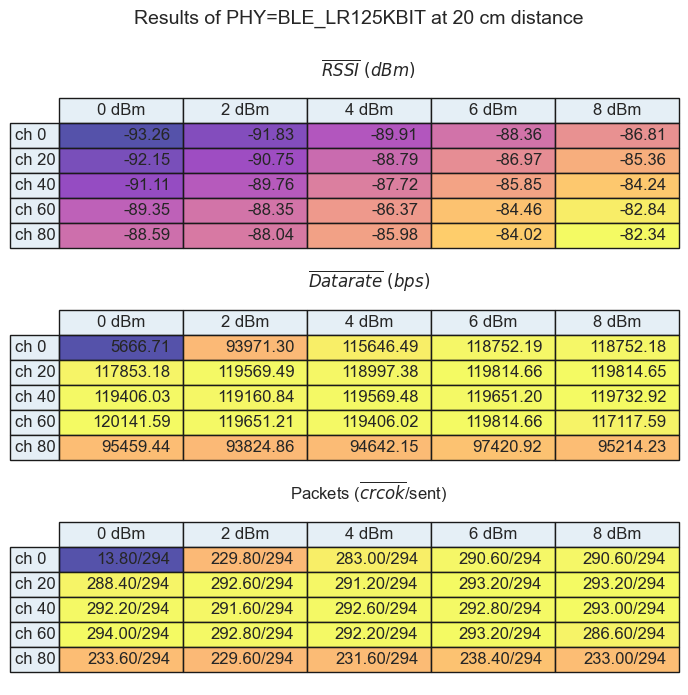

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import seaborn as sns
sns.set_theme()

table_mode_0_results = table_mode_0.fetchall()

fig, axs = plt.subplots(nrows=3, figsize=(8, 5))
# fig.tight_layout()
plt.subplots_adjust(bottom=0, top=1.2)
fig.suptitle('Results of PHY=BLE_LR125KBIT at 20 cm distance', fontsize=14, y=1.35)


def plot_cell_data(axis, table, table_formatter, color_mapper, title):
    cell_text = [[None for _ in range(5)] for _ in range(5)]
    cell_colors = [[None for _ in range(5)] for _ in range(5)]
    for i in range(5):
        for j in range(5):
            row_index = i*5 + j
    
            data = table[row_index]
            cell_text[i][j] = table_formatter(data)
            cell_colors[i][j] = color_mapper(data)
            
    axis.axis('off')
    axis.set_title(title)
    axis.table(
        cellText=cell_text,
        cellColours=cell_colors,
        
        rowLabels=('ch 0', 'ch 20', 'ch 40', 'ch 60', 'ch 80'),
        colLabels=('0 dBm', '2 dBm', '4 dBm', '6 dBm', '8 dBm'),
    
        rowColours=plt.cm.BuPu(np.full(5, 0.1)),
        colColours=plt.cm.BuPu(np.full(5, 0.1)),
        
        loc='center',
    ).scale(1, 1.5)


def create_color_mapper(minima, maxima):
    norm = mcolors.Normalize(vmin=minima, vmax=maxima, clip=True)
    return cm.ScalarMappable(norm=norm, cmap=cm.plasma)
    
mapper = create_color_mapper(min(-r[2] for r in table_mode_0_results), max(-r[2] for r in table_mode_0_results))
plot_cell_data(axs[0], table_mode_0_results, lambda d: f'-{d[2]:.2f}',lambda d: mapper.to_rgba(-d[2], alpha=0.7),r'$\overline{RSSI} ~ (dBm)$',)

mapper = create_color_mapper(min(r[3] for r in table_mode_0_results), max(r[3] for r in table_mode_0_results))
plot_cell_data(axs[1], table_mode_0_results, lambda d: f'{d[3]:.2f}', lambda d: mapper.to_rgba(d[3], alpha=0.7), r'$\overline{Data rate} ~ (bps)$')

mapper = create_color_mapper(min(r[6]/r[4] for r in table_mode_0_results), max(r[6]/r[4] for r in table_mode_0_results))
plot_cell_data(axs[2], table_mode_0_results, lambda d: f'{d[6]:.2f}/{int(d[4])}', lambda d: mapper.to_rgba(d[6]/d[4], alpha=0.7), r'Packets ($\overline{crcok}$/sent)')

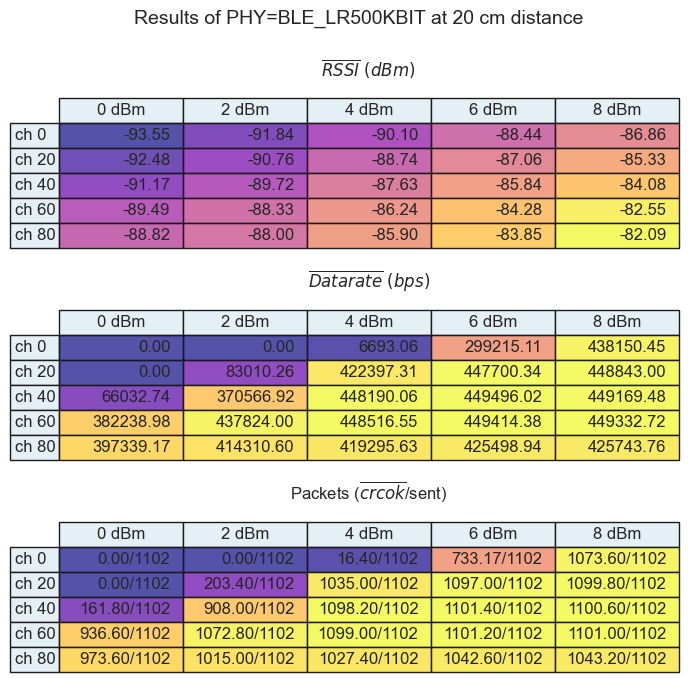

In [6]:
table_mode_1_results = table_mode_1.fetchall()

fig, axs = plt.subplots(nrows=3, figsize=(8, 5))
# fig.tight_layout()
plt.subplots_adjust(bottom=0, top=1.2)
fig.suptitle('Results of PHY=BLE_LR500KBIT at 20 cm distance', fontsize=14, y=1.35)

mapper = create_color_mapper(min(-r[2] for r in table_mode_0_results), max(-r[2] for r in table_mode_1_results))
plot_cell_data(axs[0], table_mode_1_results, lambda d: f'-{d[2]:.2f}',lambda d: mapper.to_rgba(-d[2], alpha=0.7),r'$\overline{RSSI} ~ (dBm)$',)

mapper = create_color_mapper(min(r[3] for r in table_mode_1_results), max(r[3] for r in table_mode_1_results))
plot_cell_data(axs[1], table_mode_1_results, lambda d: f'{d[3]:.2f}', lambda d: mapper.to_rgba(d[3], alpha=0.7), r'$\overline{Data rate} ~ (bps)$')

mapper = create_color_mapper(min(r[6]/r[4] for r in table_mode_1_results), max(r[6]/r[4] for r in table_mode_1_results))
plot_cell_data(axs[2], table_mode_1_results, lambda d: f'{d[6]:.2f}/{int(d[4])}', lambda d: mapper.to_rgba(d[6]/d[4], alpha=0.7), r'Packets ($\overline{crcok}$/sent)')

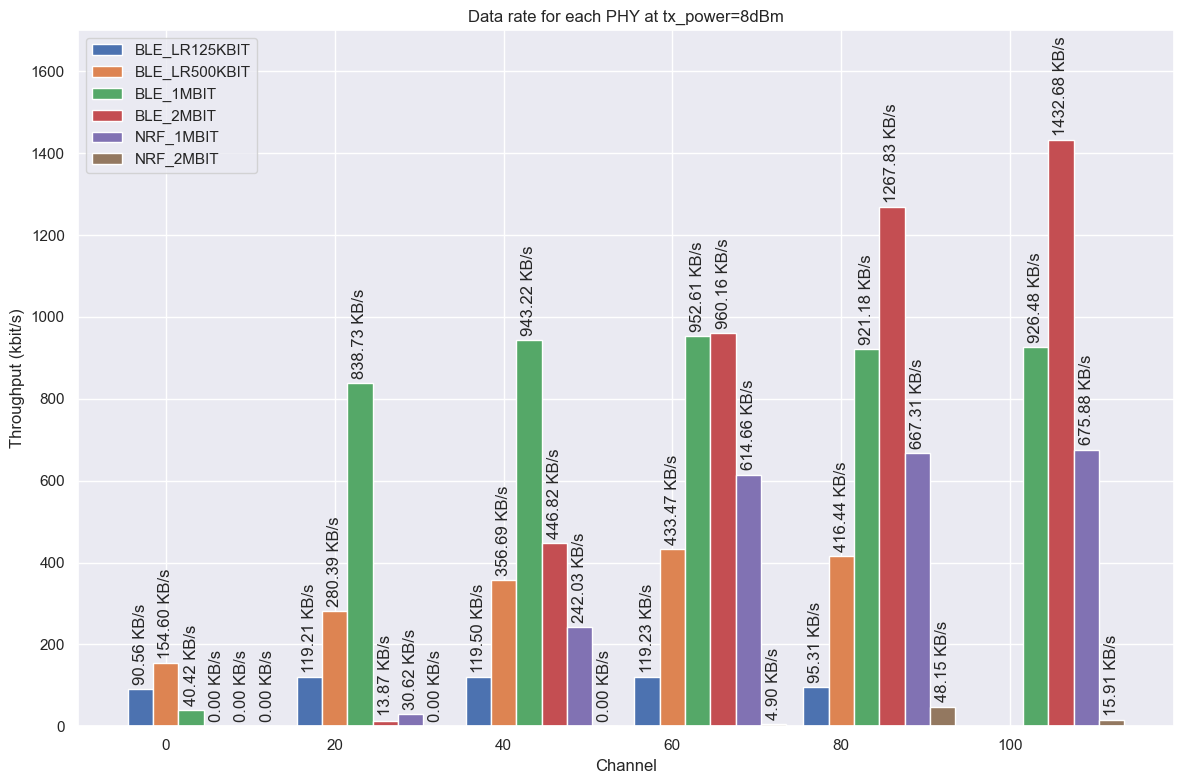

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(6)
width = 0.15
multiplier = 0

data = duckdb.sql('SELECT avg(throughput_bps) FROM df WHERE tx_mode = 0 GROUP BY tx_channel ORDER BY tx_channel').fetchall()
offset = width * multiplier
rects = ax.bar(np.arange(5) + offset, [m[0]/1000 for m in data], width, label=MODE_NAMES[0], align='center')
ax.bar_label(rects, padding=3, fmt=lambda x: f'{x:.2f} KB/s', rotation=90)
multiplier += 1

data = duckdb.sql('SELECT avg(throughput_bps) FROM df WHERE tx_mode = 1 GROUP BY tx_channel ORDER BY tx_channel').fetchall()
offset = width * multiplier
rects = ax.bar(np.arange(5) + offset, [m[0]/1000 for m in data], width, label=MODE_NAMES[1], align='center')
ax.bar_label(rects, padding=3, fmt=lambda x: f'{x:.2f} KB/s', rotation=90)
multiplier += 1

for mode in (2, 3, 4, 5):
    data = duckdb.sql(f'SELECT throughput_bps FROM df WHERE tx_mode = {mode} ORDER BY tx_channel').fetchall()
    offset = width * multiplier
    rects = ax.bar(x + offset, [m[0]/1000 for m in data], width, label=MODE_NAMES[mode], align='center')
    ax.bar_label(rects, padding=3, fmt=lambda x: f'{x:.2f} KB/s', rotation=90)
    multiplier += 1

ax.set_title('Data rate for each PHY at tx_power=8dBm')
ax.set_ylabel('Throughput (kbit/s)')
ax.set_xlabel('Channel')
ax.set_xticks(x + width, (0, 20, 40, 60, 80, 100))
ax.set_ylim(0, 1700)
ax.legend(loc='upper left')

fig.tight_layout()

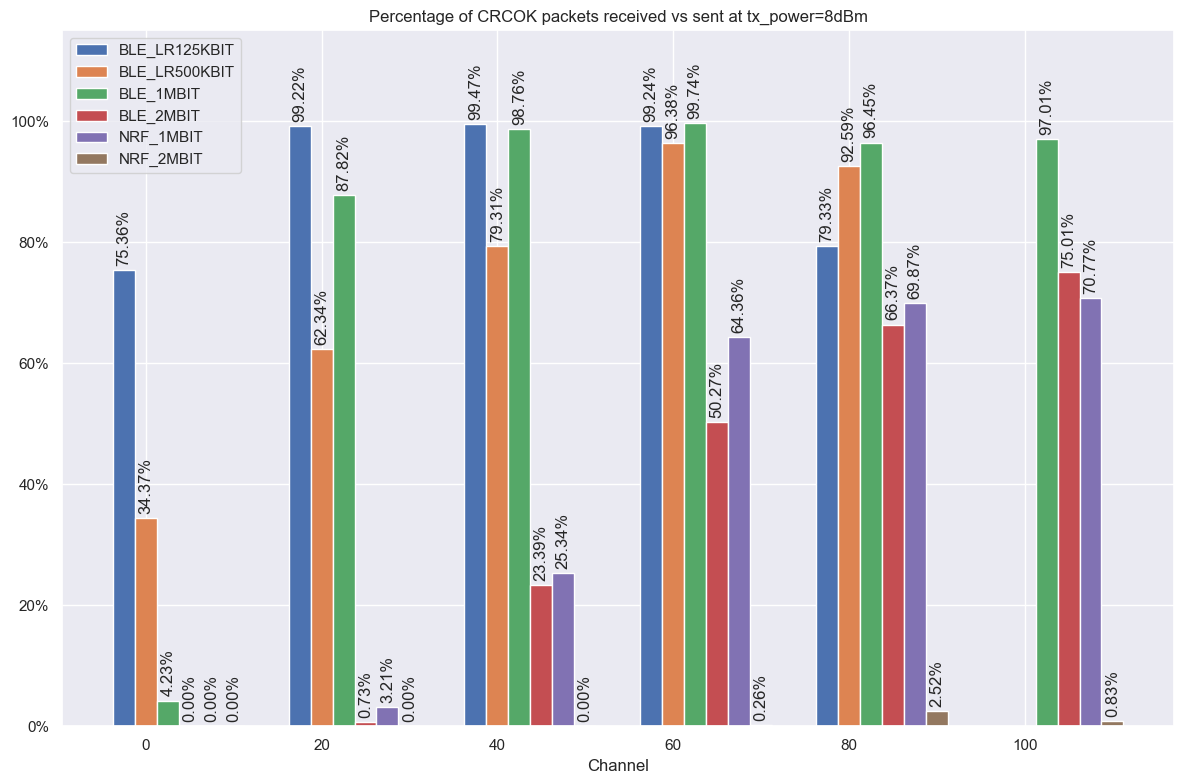

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(6)
width = 0.125
multiplier = 0

data = duckdb.sql('SELECT avg(crcok / sent)*100 FROM df WHERE tx_mode = 0 GROUP BY tx_channel ORDER BY tx_channel').fetchall()
offset = width * multiplier
rects = ax.bar(np.arange(5) + offset, [m[0] for m in data], width, label=MODE_NAMES[0], align='center')
ax.bar_label(rects, padding=3, fmt=lambda x: f'{x:.2f}%', rotation=90)
multiplier += 1

data = duckdb.sql('SELECT avg(crcok / sent)*100 FROM df WHERE tx_mode = 1 GROUP BY tx_channel ORDER BY tx_channel').fetchall()
offset = width * multiplier
rects = ax.bar(np.arange(5) + offset, [m[0] for m in data], width, label=MODE_NAMES[1], align='center')
ax.bar_label(rects, padding=3, fmt=lambda x: f'{x:.2f}%', rotation=90)
multiplier += 1

for mode in (2, 3, 4, 5):
    data = duckdb.sql(f'SELECT (crcok / sent)*100 FROM df WHERE tx_mode = {mode} ORDER BY tx_channel').fetchall()
    offset = width * multiplier
    rects = ax.bar(x + offset, [m[0] for m in data], width, label=MODE_NAMES[mode], align='center')
    ax.bar_label(rects, padding=3, fmt=lambda x: f'{x:.2f}%', rotation=90)
    multiplier += 1

ax.set_title('Percentage of CRCOK packets received vs sent at tx_power=8dBm')
ax.set_xlabel('Channel')
# ax.set_ylabel('')
ax.set_xticks(x + width, (0, 20, 40, 60, 80, 100))
ax.yaxis.set_major_formatter('{x:.0f}%')
ax.set_ylim(0, 115)
ax.legend(loc='upper left')

fig.tight_layout()

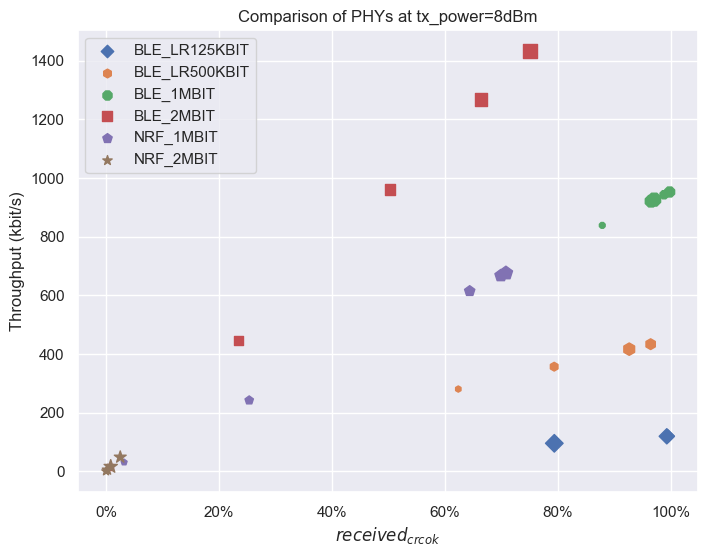

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

for mode, marker in ((0, 'D'), (1, 'h'), (2, '8'), (3, 's'), (4, 'p'), (5, '*')):
    x_data = duckdb.sql(f'SELECT avg(throughput_bps) / 1000 FROM df WHERE tx_mode = {mode} GROUP BY tx_channel ORDER BY tx_channel').fetchall()
    y_data = duckdb.sql(f'SELECT avg((crcok / sent)*100) FROM df WHERE tx_mode = {mode} GROUP BY tx_channel ORDER BY tx_channel').fetchall()
    
    if mode in (0, 1):
        ax.scatter(y_data, x_data, (0, 20, 40, 60, 80), label=MODE_NAMES[mode], marker=marker)
    else:
        ax.scatter(y_data, x_data, (0, 20, 40, 60, 80, 100), label=MODE_NAMES[mode], marker=marker)

ax.set_title('Comparison of PHYs at tx_power=8dBm')
ax.xaxis.set_major_formatter('{x:.0f}%')
ax.set_ylabel('Throughput (kbit/s)')
ax.set_xlabel(r'$received_{crcok}$')
ax.legend()

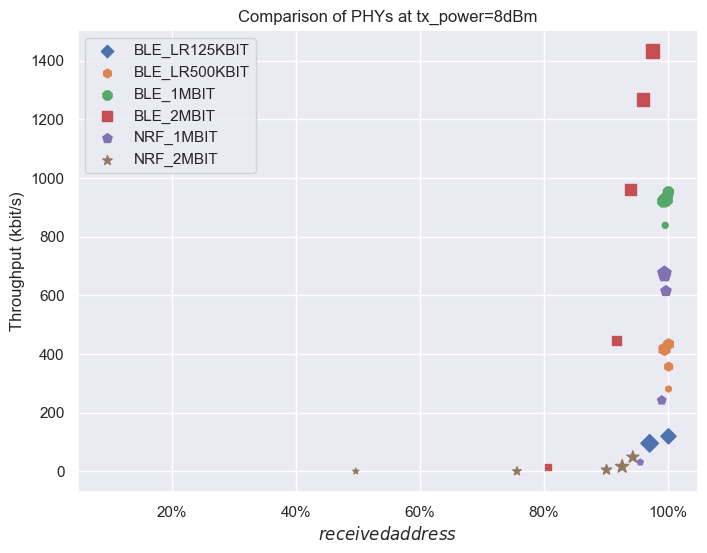

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

for mode, marker in ((0, 'D'), (1, 'h'), (2, '8'), (3, 's'), (4, 'p'), (5, '*')):
    x_data = duckdb.sql(f'SELECT avg(throughput_bps) / 1000 FROM df WHERE tx_mode = {mode} GROUP BY tx_channel ORDER BY tx_channel').fetchall()
    y_data = duckdb.sql(f'SELECT avg((received / sent)*100) FROM df WHERE tx_mode = {mode} GROUP BY tx_channel ORDER BY tx_channel').fetchall()
    
    if mode in (0, 1):
        ax.scatter(y_data, x_data, (0, 20, 40, 60, 80), label=MODE_NAMES[mode], marker=marker)
    else:
        ax.scatter(y_data, x_data, (0, 20, 40, 60, 80, 100), label=MODE_NAMES[mode], marker=marker)

ax.set_title('Comparison of PHYs at tx_power=8dBm')
ax.xaxis.set_major_formatter('{x:.0f}%')
ax.set_ylabel('Throughput (kbit/s)')
ax.set_xlabel(r'$received{address}$')
ax.legend()

In [11]:
headers = (
    'tx_mode', 'tx_channel', 'tx_power', 'packet_size',
    'sent', 'received', 'crcok', 'total_rssi',
    'ticks', 'time_s',
)

df = pd.read_csv('results_packetsize_20cm.csv', names=headers)
df.head()

,tx_mode,tx_channel,tx_power,packet_size,sent,received,crcok,total_rssi,ticks,time_s
0,0,50,8,16,2969,2557,2556,199253,39996957,4.99962
1,0,50,8,16,2969,2970,2969,231549,39996959,4.99962
2,0,50,8,16,2969,2970,2969,231638,39996957,4.99962
3,0,50,8,16,2969,2970,2969,231648,39996957,4.99962
4,0,50,8,16,2969,2970,2969,231740,39996959,4.99962


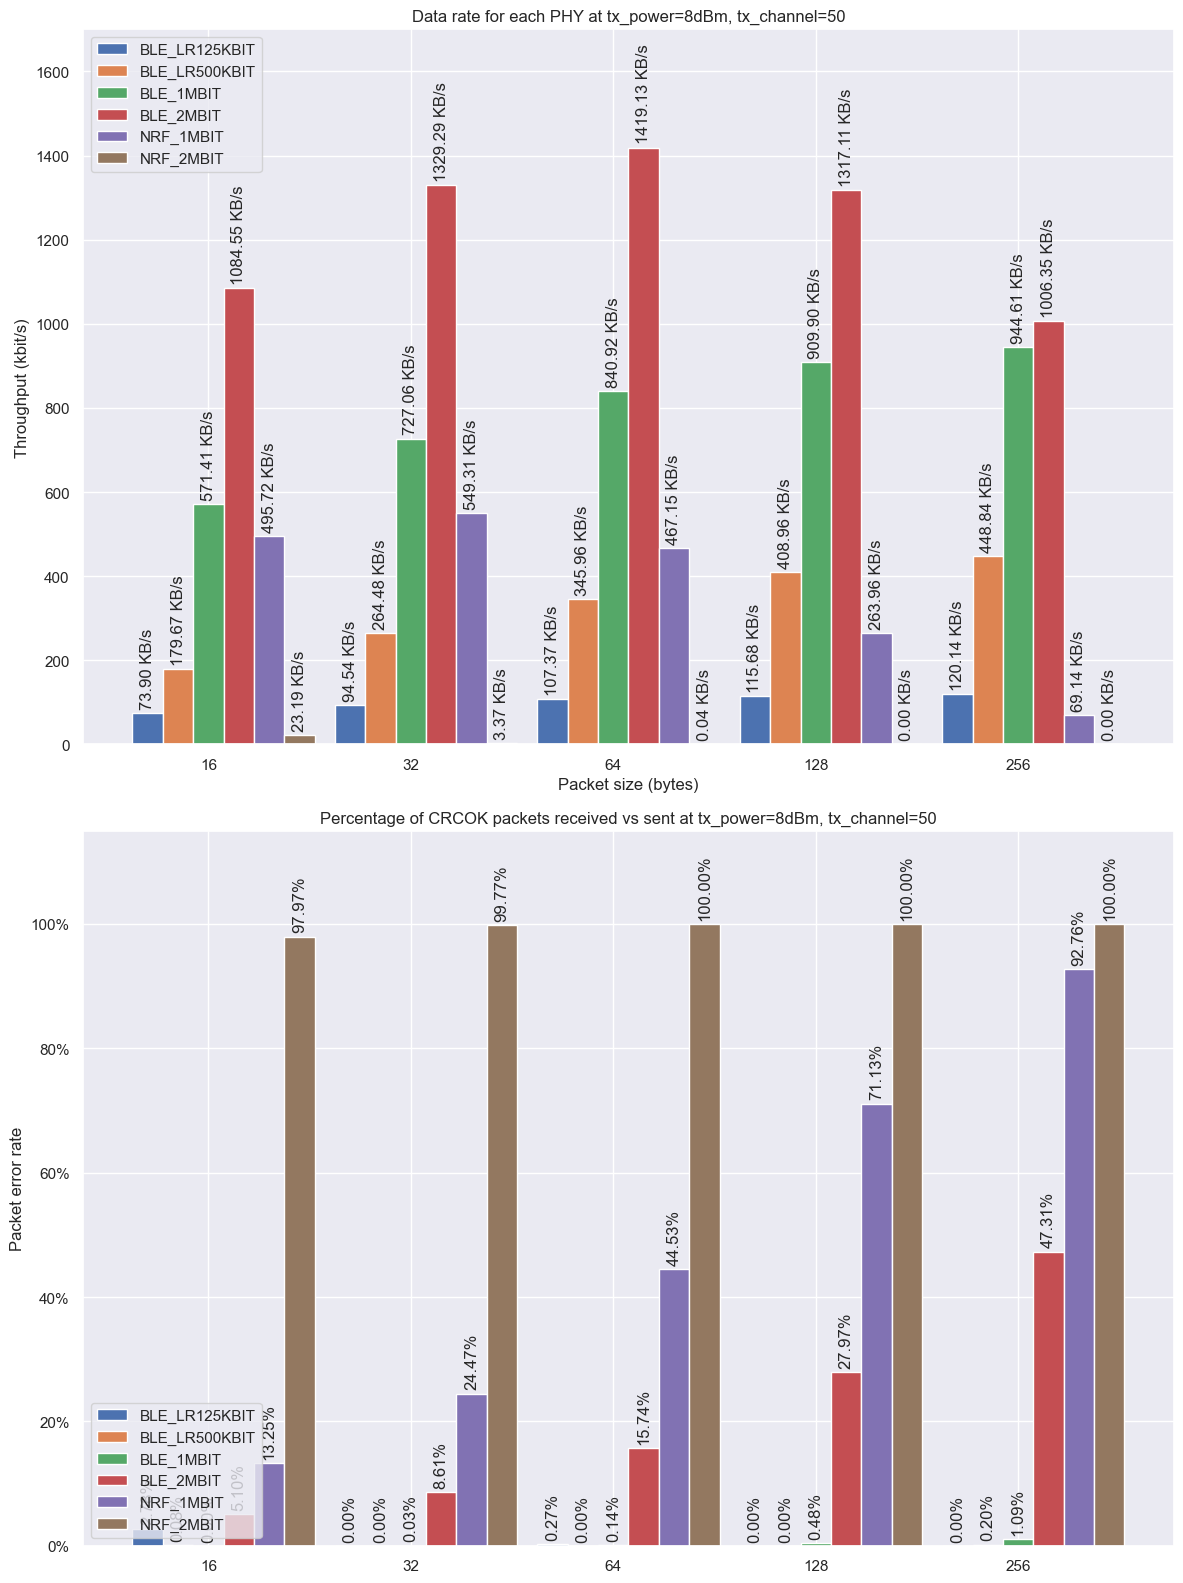

In [13]:
fig, axs = plt.subplots(figsize=(12, 16), nrows=2)

x = np.arange(5)
width = 0.15
multiplier = 0

for mode in range(6):
    data = duckdb.sql(f'SELECT AVG(crcok * packet_size * 8 / time_s) / 1000 FROM df WHERE tx_mode = {mode} AND tx_channel = 50 GROUP BY packet_size ORDER BY packet_size').fetchall()
    offset = width * multiplier
    rects = axs[0].bar(x + offset, [m[0] for m in data], width, label=MODE_NAMES[mode], align='center')
    axs[0].bar_label(rects, padding=3, fmt=lambda x: f'{x:.2f} KB/s', rotation=90)
    multiplier += 1

axs[0].set_title('Data rate for each PHY at tx_power=8dBm, tx_channel=50')
axs[0].set_ylabel('Throughput (kbit/s)')
axs[0].set_xlabel('Packet size (bytes)')
axs[0].set_xticks(x + 2*width, (16, 32, 64, 128, 256))
axs[0].set_ylim(0, 1700)
axs[0].legend(loc='upper left')

x = np.arange(5)
width = 0.15
multiplier = 0

for mode in range(6):
    data = duckdb.sql(f'SELECT 100 - AVG(crcok / sent)*100 FROM df WHERE tx_mode = {mode} AND tx_channel = 50 GROUP BY packet_size ORDER BY packet_size').fetchall()
    offset = width * multiplier
    rects = axs[1].bar(x + offset, [m[0] for m in data], width, label=MODE_NAMES[mode], align='center')
    axs[1].bar_label(rects, padding=3, fmt=lambda x: f'{x:.2f}%', rotation=90)
    multiplier += 1

axs[1].set_title('Percentage of CRCOK packets received vs sent at tx_power=8dBm, tx_channel=50')
axs[0].set_xlabel('Packet size (bytes)')
axs[1].set_ylabel('Packet error rate')
axs[1].set_xticks(x + 2*width, (16, 32, 64, 128, 256))
axs[1].yaxis.set_major_formatter('{x:.0f}%')
axs[1].set_ylim(0, 115)
axs[1].legend(loc='lower left')

fig.tight_layout()